In [1]:
import os
import sys
import csv
import requests
import nbm_funcs

import numpy as np
import pandas as pd
import xarray as xr
import multiprocessing as mp

import seaborn as sns
import scipy.stats as scipy
import urllib.request as req
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

***
***
# Configuration
Select 'site' to evaluate, modify 'vsite' if an alternate verification site is preferred<br>
Fixed 'date0' at the start of the NBM v3.2 period (2/20/2020)<br>
Full lead time is 263 hours - Note if date1 is within this period, there will be missing verification data as it does not exist yet!

In [2]:
# NBM 1D Viewer Site to use
site = nbm_funcs._site = 'KMSO'
vsite = site

# Data Range
lead_time_end = 263
init_hours = nbm_funcs._init_hours = [13]#[1, 7, 13, 19]

date0 = nbm_funcs._date0 = datetime(2020, 6, 1)#3, 1)
date1 = nbm_funcs._date1 = datetime(2020, 7, 1)#today

In [3]:
sitepath = site if site == vsite else '_'.join([site, vsite])

datadir = nbm_funcs._datadir = '../archive/%s/data/'%sitepath
os.makedirs(datadir, exist_ok=True)

figdir = nbm_funcs._figdir = '../archive//%s/figures/'%sitepath
os.makedirs(figdir, exist_ok=True)

dates = nbm_funcs._dates = pd.date_range(date0, date1, freq='1D')
date2 = nbm_funcs._date2 = date1 + timedelta(hours=lead_time_end)

print(('\nForecast Site: {}\nVerif Site: {}\nInit Hours: '+
      '{}\nFirst Init: {}\nLast Init: {}\nLast Verif: {}').format(
    site, vsite, init_hours, date0, date1, date2))


Forecast Site: KMSO
Verif Site: KMSO
Init Hours: [13]
First Init: 2020-06-01 00:00:00
Last Init: 2020-07-01 00:00:00
Last Verif: 2020-07-11 23:00:00


***
***
# Obtain observation data from SynopticLabs (MesoWest) API
These are quality-controlled precipitation observations with adjustable accumulation periods<br>
See more at: https://developers.synopticdata.com/mesonet/v2/stations/precipitation/
<br><br>
If no observation file exists, will download and save for future use

In [4]:
# Get metadata for the select point
meta_base = 'https://api.synopticdata.com/v2/stations/metadata?'
api_token = '&token=a2386b75ecbc4c2784db1270695dde73'
meta_site = '&stid=%s&complete=1'%site
url = meta_base + api_token + meta_site
# print(url)

site_meta_raw = requests.get(url).json()
# print(meta_raw['STATION'][0])

zone = site_meta_raw['STATION'][0]['NWSZONE']
cwa = site_meta_raw['STATION'][0]['CWA']

print('Site: %s\nCWA: %s\nZone: %s'%(site, cwa, zone))

Site: KMSO
CWA: MSO
Zone: MT005


In [5]:
# Get a list of sites in the CWA that report precip
precip_base = 'https://api.synopticdata.com/v2/stations/precip?&complete=1&interval=6'
zone_query = '&nwszone=%s'%zone
cwa_query = '&cwa=%s'%cwa
date_query = '&start=%s&end=%s'%(
    date0.strftime('%Y%m%d%H%M'),
    (date0+timedelta(hours=6)).strftime('%Y%m%d%H%M'))

# We could query for a list of relevant zones within a CWA here
# Then pass a list of zones to the zone query
# !Add later!

# Fix this later! Temp fix to expand the zone for more NWS/FAA/RAWS stations
# Due to 1D Viewer file limitation - Ask Chad for advice?
zone_query = cwa_query

url = precip_base + api_token + zone_query + date_query
zone_meta_raw = requests.get(url).json()

meta = []
for station in zone_meta_raw['STATION']:
    
    # We need to get back to a zone query - for now this will work with a CWA query to only hit sites that exist within a CWA    
    if (('NWS' in station['SHORTNAME']) | ('RAWS' in station['SHORTNAME']) & (station['STID'][0] == 'K')):
        meta.append({k:station[k] for k in station.keys() if type(station[k]) == str})
        
meta = pd.DataFrame(meta).set_index('STID')

meta

,NWSFIREZONE,ELEV_DEM,TIMEZONE,SGID,SHORTNAME,ELEVATION,GACC,STATUS,LONGITUDE,COUNTY,STATE,CWA,NWSZONE,ID,MNET_ID,NAME,COUNTRY,LATITUDE,WIMS_ID
STID,,,,,,,,,,,,,,,,,,,
KBTM,MSO111,5538.1,America/Denver,NR08,NWS/FAA,5545,NRCC,ACTIVE,-112.49750,Silver Bow,MT,MSO,MT007,116,1,"Butte, Bert Mooney Airport",US,45.95472,NaN
KMLP,MSO106,6000.7,America/Los_Angeles,NR01,NWS/FAA,6001,NRCC,ACTIVE,-115.66972,Mineral,MT,MSO,MT004,271,1,"Mullan Pass, Mullan Pass Vor",US,47.45417,NaN
KMSO,MSO108,3192.3,America/Denver,NR04,NWS/FAA,3199,NRCC,ACTIVE,-114.09250,Missoula,MT,MSO,MT005,277,1,"Missoula, Missoula International Airport",US,46.92083,NaN
KP69,MSO103,1466.5,America/Los_Angeles,NR06,NWS/FAA,1466,NRCC,ACTIVE,-115.59639,,ID,MSO,ID006,320,1,Lowell,US,46.14417,NaN
KGIC,MSO102,3271,America/Los_Angeles,NR05,NWS/FAA,3287,NRCC,ACTIVE,-116.13257,Idaho,ID,MSO,ID007,361,1,Grangeville - Idaho County Airport,US,45.94111,NaN
KSMN,PIH476,4038.7,America/Boise,GB02,NWS/FAA,4045,GBCC,ACTIVE,-113.88333,Lemhi,ID,MSO,ID010,392,1,"Salmon, Lemhi County Airport",US,45.11667,NaN
KELI1,MSO103,2729.7,America/Los_Angeles,NR03,RAWS,2739,NRCC,ACTIVE,-115.260833,Clearwater,ID,MSO,ID005,2043,2,KELLY,US,46.718100,100708
KRCI1,PIH476,5210,America/Boise,GB02,RAWS,5200,GBCC,ACTIVE,-113.895028,Lemhi,ID,MSO,ID010,2044,2,KRILEY CREEK,US,45.355944,101315
KGPI,MSO104,2959.3,America/Denver,NR02,NWS/FAA,2972,NRCC,ACTIVE,-114.26361,Flathead,MT,MSO,MT003,14675,1,"Kalispell, Glacier Park International Airport",US,48.30417,NaN


In [6]:
with mp.get_context('fork').Pool(8) as p:
    obs = p.map(nbm_funcs.get_precip_obs_mp, meta.index.values, chunksize=1)
    p.close()
    p.join()

obs = pd.concat(obs).sort_index()
    
mm_in = 1/25.4
obs *= mm_in
[obs.rename(columns={k:k.replace('mm', 'in')}, inplace=True) for k in obs.keys()]

# OPTIONAL! Drop NaN rows... may help elim lower qual data
obs = obs.dropna(how='all')

sites = np.unique(obs.index)

print(sites)
print(obs.shape)
obs.head(10)

[(Timestamp('2020-06-02 00:00:00'), 'KBTM')
 (Timestamp('2020-06-02 00:00:00'), 'KELI1')
 (Timestamp('2020-06-02 00:00:00'), 'KGIC') ...
 (Timestamp('2020-07-12 00:00:00'), 'KP69')
 (Timestamp('2020-07-12 00:00:00'), 'KRCI1')
 (Timestamp('2020-07-12 00:00:00'), 'KSMN')]
(1434, 3)


6h_precip_in  12h_precip_in  24h_precip_in
ValidTime           Site                                             
2020-06-02 00:00:00 KBTM       0.001000       0.001000       0.001000
                    KELI1      0.020000       0.020000       0.020000
                    KGIC       0.010000       0.070000       0.070000
                    KGPI       0.000984       0.000984       0.000984
                    KMLP       0.021969       0.021969       0.021969
                    KMSO       0.003937       0.003937       0.003937
                    KP69       0.020000       0.020000       0.020000
                    KRCI1      0.000000       0.000000       0.000000
                    KSMN       0.001000       0.001000       0.001000
2020-06-02 12:00:00 KBTM       0.000000       0.003000            NaN

In [7]:
obs.describe().T

,count,mean,std,min,25%,50%,75%,max
6h_precip_in,1432.0,0.025296,0.077494,0.0,0.0,0.000000,0.001969,0.81
12h_precip_in,724.0,0.049482,0.128197,0.0,0.0,0.000000,0.020246,1.25
24h_precip_in,717.0,0.101034,0.225537,0.0,0.0,0.000984,0.090000,1.69


***
***
# Obtain NBM forecast data from NBM 1D Viewer (csv file API)
These are the NBM 1D output files extracted from the viewer with 3 set accumulation periods<br>
See more at: https://hwp-viz.gsd.esrl.noaa.gov/wave1d/?location=KSLC&col=2&hgt=1&obs=true&fontsize=1&selectedgroup=Default
<br><br>
If no forecast file exists, will download and save for future use. This can take some time.

In [8]:
with mp.get_context('fork').Pool(8) as p:    
    nbm_mp = p.map(nbm_funcs.get_nbm_1d, meta.index, chunksize=1)
    p.close()
    p.join()

nbm_mp = np.array(nbm_mp)

for i, stid in enumerate(nbm_mp[:, 0]):
    nbm_mp[i][1]['Site'] = np.full(nbm_mp[i][1].index.size, fill_value=stid, dtype='U10')
    nbm_mp[i][1] = nbm_mp[i][1].reset_index().set_index(['InitTime', 'ValidTime', 'Site'])
    
nbm = pd.concat(nbm_mp[:, 1]).sort_index()

# Convert mm to in
# nbm = pd.DataFrame([nbm['LeadTime']] + [nbm[k] * mm_in for k in nbm.keys() if 'LeadTime' not in k]).T
nbm *= mm_in

lead = [row[1]-row[0] for row in nbm.index]
lead = np.array([1 + row.days*24 + (row.seconds/3600) for row in lead], dtype=int)
nbm.insert(0, 'LeadTime', lead)

# Nix values where lead time shorter than acc interval
for k in [k for k in nbm.keys() if k != 'LeadTime']:
    if 'APCP24hr' in k:
        nbm[k][nbm['LeadTime'] < 24] = np.nan
    elif 'APCP12hr' in k:
        nbm[k][nbm['LeadTime'] < 12] = np.nan
    elif 'APCP6r' in k:
        nbm[k][nbm['LeadTime'] < 6] = np.nan
    else:
        pass
    
nbm = nbm.dropna(subset=[k for k in nbm.keys() if k != 'LeadTime'], how='all')
nbm.tail(25)

LeadTime  APCP12hr_surface  \
InitTime            ValidTime           Site                                
2020-07-01 13:00:00 2020-07-12 00:00:00 KGIC        252          0.000000   
                                        KGPI        252          0.000000   
                                        KMLP        252          0.000000   
                                        KMSO        252          0.000000   
                                        KP69        252          0.000000   
                                        KRCI1       252          0.000000   
                                        KSMN        252          0.000000   
                    2020-07-12 06:00:00 KBTM        258          0.004921   
                                        KELI1       258          0.000236   
                                        KGIC        258          0.000000   
                                        KGPI        258          0.000000   
                                        KMLP        258          0.000000   
                                        KMSO        258          0.000000   
                                        KP69        258          0.000000   
                                        KRCI1       258          0.000000   
                                        KSMN        258          0.000000   
                    2020-07-12 12:00:00 KBTM        264          0.000000   
                                        KELI1       264          0.000000   
                                        KGIC        264          0.000000   
                                        KGPI        264          0.000000   
                                        KMLP        264          0.000000   
                                        KMSO        264          0.000000   
                                        KP69        264          0.000000   
                                        KRCI1       264          0.000000   
                                        KSMN        264          0.000000   

                                               APCP12hr_surface_1% level  \
InitTime            ValidTime           Site                               
2020-07-01 13:00:00 2020-07-12 00:00:00 KGIC                         0.0   
                                        KGPI                         0.0   
                                        KMLP                         0.0   
                                        KMSO                         0.0   
                                        KP69                         0.0   
                                        KRCI1                        0.0   
                                        KSMN                         0.0   
                    2020-07-12 06:00:00 KBTM                         0.0   
                                        KELI1                        0.0   
                                        KGIC                         0.0   
                                        KGPI                         0.0   
                                        KMLP                         0.0   
                                        KMSO                         0.0   
                                        KP69                         0.0   
                                        KRCI1                        0.0   
                                        KSMN                         0.0   
                    2020-07-12 12:00:00 KBTM                         0.0   
                                        KELI1                        0.0   
                                        KGIC                         0.0   
                                        KGPI                         0.0   
                                        KMLP                         0.0   
                                        KMSO                         0.0   
                                        KP69                         0.0   
                                        KRCI1                      

In [9]:
# Display some basic stats
nbm.loc[:, ['APCP6hr_surface', 'APCP6hr_surface_70% level', 'APCP6hr_surface_50% level',
            'APCP12hr_surface', 'APCP12hr_surface_70% level', 'APCP12hr_surface_50% level',
            'APCP24hr_surface', 'APCP24hr_surface_70% level', 'APCP24hr_surface_50% level'
            ]].describe().T

,count,mean,std,min,25%,50%,75%,max
APCP6hr_surface,11610.0,0.021702,0.057663,0.0,0.0,0.000000,0.000000,0.620000
APCP6hr_surface_70% level,11880.0,0.021659,0.059508,0.0,0.0,0.000000,0.003898,0.555354
APCP6hr_surface_50% level,11880.0,0.008825,0.033070,0.0,0.0,0.000000,0.000000,0.442756
APCP12hr_surface,11610.0,0.058457,0.127109,0.0,0.0,0.000000,0.045453,0.902756
APCP12hr_surface_70% level,11610.0,0.049685,0.110198,0.0,0.0,0.000000,0.041319,0.929173
APCP12hr_surface_50% level,11610.0,0.022439,0.067527,0.0,0.0,0.000000,0.000039,0.693425
APCP24hr_surface,6480.0,0.121956,0.225039,0.0,0.0,0.000000,0.144163,1.427520
APCP24hr_surface_70% level,6480.0,0.123999,0.207953,0.0,0.0,0.029724,0.155541,1.474134
APCP24hr_surface_50% level,6480.0,0.065286,0.143350,0.0,0.0,0.000000,0.052982,1.147047


#### Plot the distribution of precipitation observations vs forecasts for assessment of representativeness

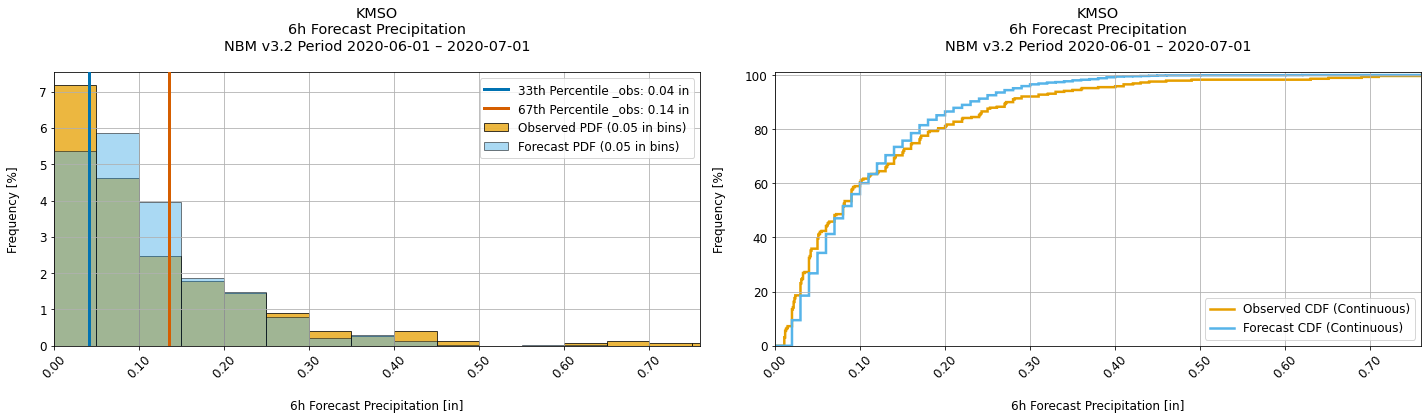

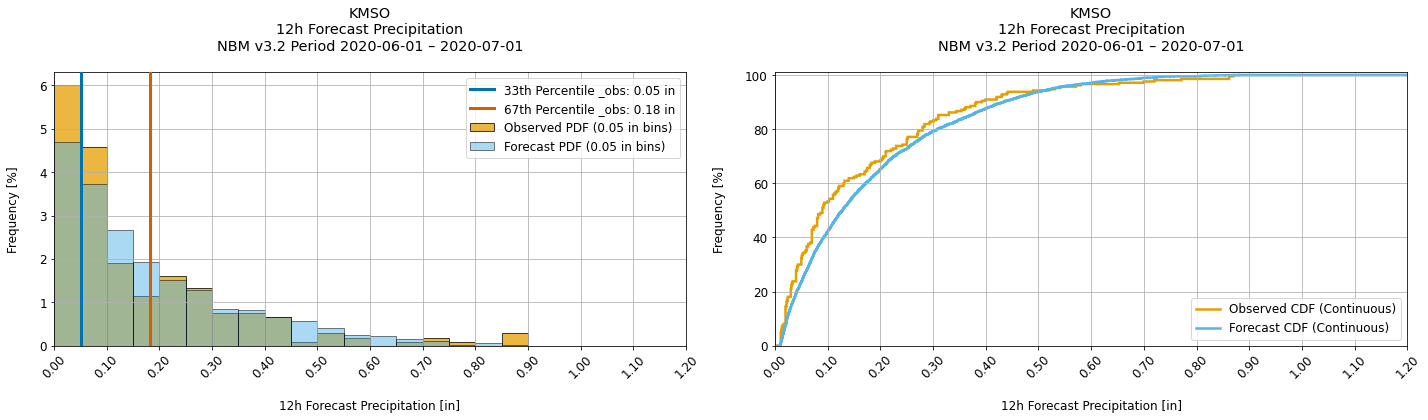

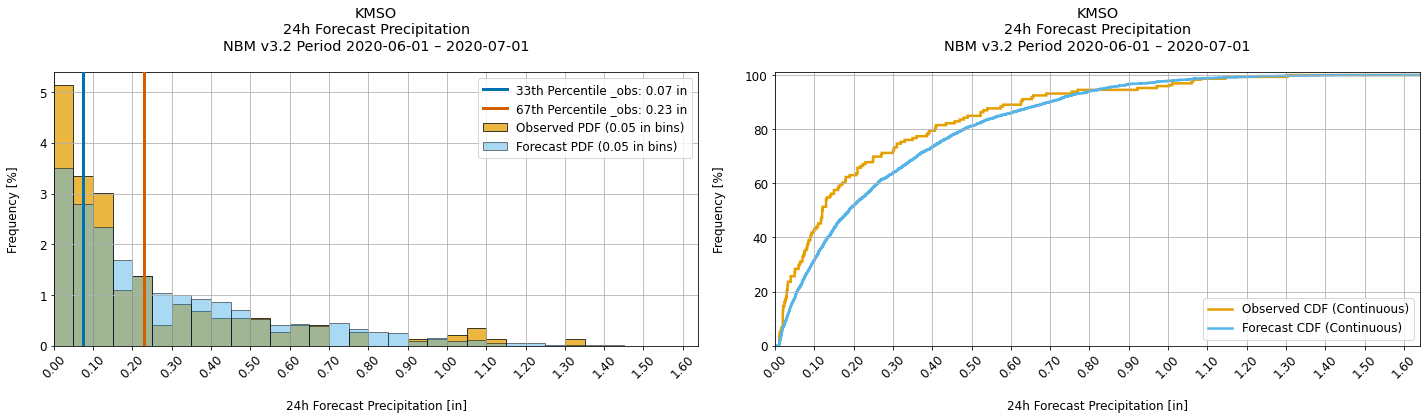

{6: array([0.        , 0.04167323, 0.13506693, 0.81      ]),
 12: array([0.        , 0.05127953, 0.18334646, 1.25      ]),
 24: array([0.        , 0.07295276, 0.23      , 1.69      ])}

In [10]:
thresh_id = nbm_funcs._thresh_id = {'Small':[0, 1], 'Medium':[1, 2], 'Large':[2, 3], 'All':[0, 3]}

# 33rd, 67th percentile determined above
thresholds = nbm_funcs._thresholds = {interval:nbm_funcs.apcp_dist_plot(obs, nbm, interval, show=True) 
              for interval in [6, 12, 24]}

thresholds